# Quantum transforms and noise: A faulty superconducting device

If you have ever tried to run a job on a real quantum device, you may have noticed that your results are not as accurate as you would've hoped for. Minimizing these errors is, in fact, one of the main goals of quantum engineering. Why do these errors happen? The reason is that **gates are noisy**. When a qubit goes through a gate, it gets entangled with the quantum state of the environment (i.e. our lab). This is an unavoidable experimental error, since we can't isolate a quantum system completely if we want to manipulate it. Therefore, real-life gates will not transform the qubits exactly as they do on paper.

It turns out that some devices may be less error-prone than others when executing a particular task. **Gate implementation is device dependent**, which means that, often times, devices need to implement a series of gates that is equivalent to the gate we need. The implementation of extra gates results in additional errors due to noise.

For example, suppose that we are given a superconducting device that cannot implement the _CNOT_ gate directly. Instead, the device can directly apply the _iSWAP_ gate by connecting two superconducting circuits through a capacitor. Not a problem! We can write the _CNOT_ gate in terms _iSWAP_ as follows:

<img src=" 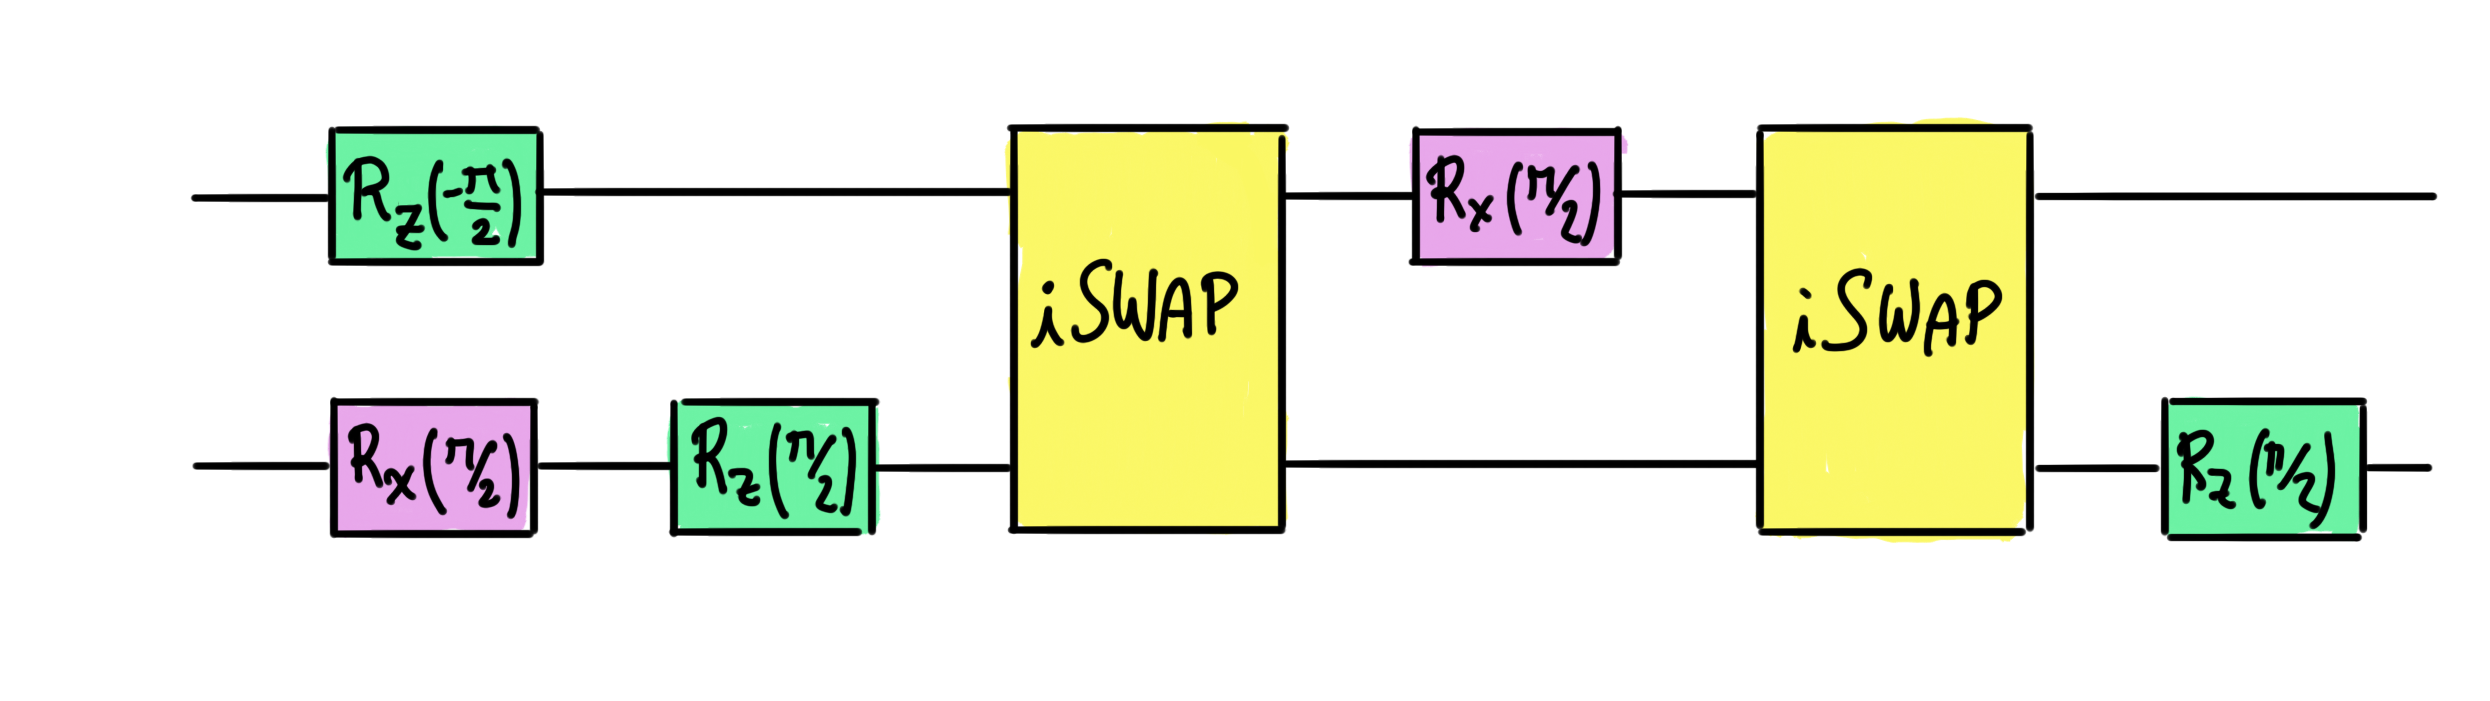">

The iSWAP gate in the above circuit introduces some noise, which we will model by adding one depolarizing channel with the at the end of each wire in the above circuit. Both depolarizing channels depend on the same noise parameter $\beta$. Additionally, we will assume that, due to a fabrication error, all of the rotation gates in the circuit above are overrotated by an angle $\theta$ (any rotation parameter $\alpha$ in the ideal circuit becomes $\alpha+\theta$ in the superconducting circuit).

Your task is to find the _average fidelity_ between an input circuit and the same circuit implemented in this (faulty) superconducting device, as a function of the parameters $\beta$ and $\theta$.

## Challenge code

You must complete the `average_fidelity` function to find the average [fidelity](https://docs.pennylane.ai/en/stable/code/api/pennylane.math.fidelity.html?highlight=fidelity) between the superconducting circuit and the ideal circuit.

The most elegant way to solve this coding challenge is to use `qml.transforms.create_decomp_expand_fn` to modify the given device `dev`, so that it automatically implements the CNOT gate as if it were the superconducting device described above.

You will need to take the average of the fidelity of many states to calculate your output. To help you with this, a set `sample` of 20 uniformly distributed points on the Bloch sphere, parametrized by their azimuthal and polar angles $\theta$ and $\phi$, in the order $[\theta, \phi]$. That is the state is given by:

$$\ket\psi = \cos(\frac{\theta}{2})\ket 0 + e^{i\phi} \sin(\frac{\theta}{2}) \ket1$$

This set has been generated using the Haar measure (don't worry too much about this, it's just a way to ensure that states are sampled without bias!). We then use a `Rot` gate to prepare the initial state. **Use this sample to calculate the average fidelity**; if you do not, your results may not match the expected output.



### Input

As input to this problem, you will be given:

*   `gate_list` array(str): A list of gates contained in the input circuit
*   `wire_list` array(arr(int)): List of lists of wires on which the gates in `gate_list` act, in order.
*   `noise_param` (float): The parameter $\beta$ of the depolarizing gate associated with the iSWAP gates.
*   `over_rot` (float): The systematic rotation error $\theta$ in the faulty implementation of the CNOT gate.



### Output

This code will output the average fidelity, a `float`, of the superconducting circuit with respect to the ideal circuit.

If your solution matches the correct one within the given tolerance specified in `check` (in this case it's an absolute tolerance of `0.01`), the output will be `"Correct!"`. Otherwise, you will receive a `"Wrong answer"` prompt.

Good luck!

In [ ]:
import functools
import json
import math
import pandas as pd
import pennylane as qml
import pennylane.numpy as np
import scipy

In [ ]:
sample = np.array([[0.88645553, 5.84095018],
        [1.76306821, 1.28529014],
        [2.09187193, 6.06022346],
        [2.7455983 , 4.10650061],
        [1.156449  , 0.05270523],
        [2.41036002, 4.1243531 ],
        [1.85975128, 6.06105961],
        [1.21447324, 4.50789405],
        [2.98670697, 2.76236853],
        [0.85240889, 4.25292296],
        [2.51060472, 0.16869898],
        [1.62333082, 0.1550452 ],
        [2.48189743, 3.74707815],
        [1.57124183, 4.57583136],
        [0.97387373, 5.09057019],
        [1.48945306, 1.62557981],
        [1.63373765, 4.45798143],
        [2.59893856, 1.05395551],
        [1.55004825, 3.8295616 ],
        [2.53605197, 2.37092827]])


In [ ]:
def average_fidelity(gate_list, wire_list, noise_param, over_rot):

    """This function returns the average fidelity of a noisy superconducting circuit
    with respect to the ideal version of such circuit, which contains CNOT gates.

    Args:
        - gate_list (list(str)): Gates, assumed to be non-parametric, contained in the ideal circuit. 
        - wire_list (list(int)): Wires on which each of the gates in gate_list act
        - noise_param (float): The noise parameter characterizing the depolarizing gate after the sqrt(iSWAP) gates
        - over_rot (float): Extra rotation angle on each rotation gate.
    Returns: 
        - (float): Average fidelity of the superconducting circuit with respect to the ideal circuit.
    """

    
    def circuit():
        """This function creates a circuit from gate_list and wire_list (You shouldn't modify this)"""
        for i in range(len(gate_list)):
            getattr(qml,gate_list[i])(wires=wire_list[i])
        
    ref_device = qml.device('default.mixed', wires = 2)

    @qml.qnode(ref_device)
    def reference_circuit(phi, theta):
        """Ideal circuit, with prior state preparation (You shouldn't modify this)"""
        qml.Rot(phi, theta, 0, wires = 0)
        circuit()
        return qml.state()
    
    dev = qml.device('default.mixed', wires = 2)
    
    cnot_rot = over_rot
    def custom_cnot(wires):  # TODO
        return [
            qml.RZ((-np.pi/2) + cnot_rot, wires = wires[0]),
            qml.RX( (np.pi/2) + cnot_rot, wires = wires[1]),
            qml.RZ( (np.pi/2) + cnot_rot, wires = wires[1]),

            qml.ISWAP(wires = [wires[0],wires[1]] ),
            
            qml.RX( (np.pi/2)+cnot_rot, wires = wires[0]),

            qml.ISWAP(wires = [wires[0],wires[1]] ),
            qml.RZ( (np.pi/2)+cnot_rot, wires = wires[1]),

            qml.DepolarizingChannel(noise_param, wires = wires[0]),
            qml.DepolarizingChannel(noise_param, wires = wires[1])
        ]


    custom_decomps = { qml.CNOT : custom_cnot}
    expand_fn = qml.transforms.create_decomp_expand_fn(custom_decomps, dev)
    dev.custom_expand(expand_fn)
    
    @qml.qnode(dev, expansion_strategy = "device")
    def superconducting_circuit(phi, theta):
        qml.Rot(phi, theta, 0, wires = 0)
        circuit()
        return qml.state()
    
    def fidelity(phi,theta):  # TODO
        """Return the fidelity of the final state of the circuit, with respect to the ideal circuit, given
        an initial state parametrized by phi and theta"""
        rho1 = reference_circuit(phi, theta)
        rho2 = superconducting_circuit(phi, theta)
        return qml.math.fidelity(rho1,rho2)


    # Return the average fidelity by running over the sample states given to you in the list "sample"
    fidelities = [fidelity(angle[1], angle[0]) for angle in sample]

    return np.mean(fidelities).astype(float)

In [ ]:
# These functions are responsible for testing the solution.

def run(test_case_input: str) -> str:
		
    ins = json.loads(test_case_input)
    output = average_fidelity(*ins)

    return str(output) 

def check(solution_output: str, expected_output: str) -> None:
    """
    Compare solution with expected.

    Args:
            solution_output: The output from an evaluated solution. Will be
            the same type as returned.
            expected_output: The correct result for the test case.

    Raises: 
            ``AssertionError`` if the solution output is incorrect in any way.
    """

    solution_output = json.loads(solution_output)
    expected_output = json.loads(expected_output)
    assert np.allclose(
        solution_output, expected_output, rtol=1e-2
    ), "Your calculated average fidelity isn't quite right."


In [ ]:
test_cases = [['[["Hadamard","CNOT","PauliZ"],[0,[0,1],0],0.0001,0.01]', '0.363157'], ['[["CNOT","PauliZ","PauliZ"],[[1,0],1,0],0.0001,0.01]', '0.445426']]

In [ ]:
for i, (input_, expected_output) in enumerate(test_cases):
    print(f"Running test case {i} with input '{input_}'...")

    try:
        output = run(input_)

    except Exception as exc:
        print(f"Runtime Error. {exc}")

    else:
        if message := check(output, expected_output):
            print(f"Wrong Answer. Have: '{output}'. Want: '{expected_output}'.")

        else:
            print("Correct!")